In [1]:
%load_ext autoreload
%autoreload 2 

import anndata as ad
from totopos.genes import perturb
from totopos.topology import simplicial
from totopos.viz import diagrams
from matplotlib import pyplot as plt 
from os.path import join
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = "retina"

plt.rcParams["figure.figsize"] = (2,2)

In [3]:
ddir = "/home/mnu/projects/topo/data/synthetic_data/dyngen/"

### Estimating the topology of a single-cell dataset

For this tutorial we'll work with a synthetic dataset corresponding to an oscillatory gene regulatory network consisting of 
100 TFs, 1000 TGs, and 500 housekeeping (HK) genes. 

In [4]:
a = ad.read_h5ad(join(ddir, "cycle_dyngen_lognorm.h5ad"))

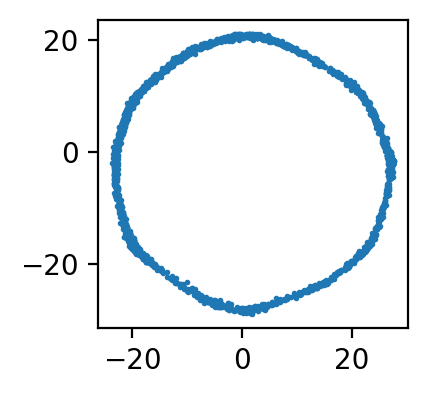

In [5]:
plt.scatter(*a.obsm["pcs"][:, :2].T,s = 1)

First, let's compute the topology of the data.

In [6]:
topology = simplicial.SimplicialTopology(a.X.A, maxdim=1, n_pts=800)
topology.compute_persistent_cohomology(verbose=True)
topology.estimate_neighborhood_threshold(neighborhood_size=350, verbose = True)

Doing TDA...
Elapsed time persistence: 16.6 seconds


Estimating PH noise floor using Kmeans neighborhoods: 100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 10.34it/s]

Found 1 topological loops.


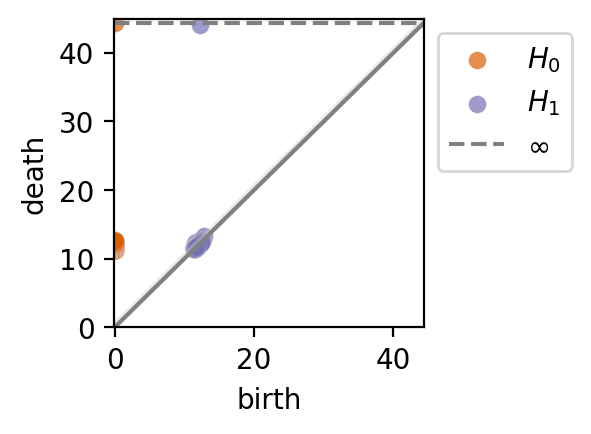

In [7]:
diagrams.plot_pers_diag_ripser(topology.ph.dgms_, conf_int=topology.neighborhood_lifetime_threshold[1])

From the persistent diagram we can see that there is 1 connected component (orange), and 1 prominent topological loop (purple).

Now, let's compute a parametrization of the loop using the persistent homology calculation.

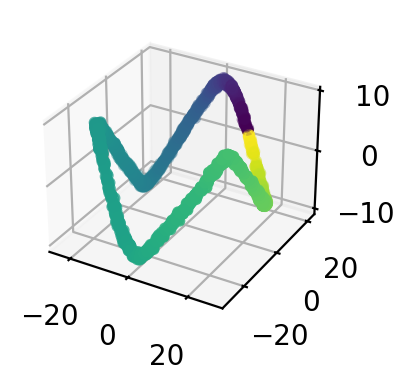

In [8]:
coords=topology.ph.get_coordinates(.7, [0], standard_range=False, check_cocycle_condition=True)
coords=coords[0]

fig = plt.figure()
ax=fig.add_subplot(projection="3d")
ax.scatter(
    *a.obsm["pcs"][:, :3].T, c = coords, s= 10
)

cell_ordering = np.argsort(coords)

### Finding genes that generate the topology. 

Now, let's calculate the genes that are important for generating the topological feature.

We have two such methods: 

* Perturbation method: Uses persistent diagram information to ask, what are the genes that are important for "refining" the topological feature via perturbing the data to remove the spurious loops. The method is cell-agnostic, meaning that it can be computed in the whole dataset.

* Eigenvector method: Laplacian eigenvectors encode the geometry of a manifold. Furthermore, laplacian eigenvectors are transiently active along manifolds. Therefore, we can ask, which genes are correlated to the laplacian eigenvectors to get the genes that are transiently active in parts of the loop, which give us a hint of genes generating the topology of the loop. The downside of the eigenvector method is that it needs to be computed in the subset of cells that form a loop. 

We suggest to use the perturbation method for small datasets ($\approx 10^3$ cells) and the eigenvector of methods for larger datasets.

In [9]:
%%time
scores, dgms = perturb.topological_gene_scores_via_perturbation(
    a[::10].X.A, max_radius = 10, n_threads = 16, n_topo_feats=1, hom_dim = 1, verbose=True
)

Calculating Vietoris-Rips filtration...
Finished filtration.
Computing persistent homology...
Finished persistent homology calculation.
Calculating gene scores...
Finished gene score calculation succesfully.
CPU times: user 1min 17s, sys: 8.99 s, total: 1min 26s
Wall time: 57.9 s


In [10]:
ranking = np.argsort(scores)[::-1]

Let's visualize the highest ranked genes. 

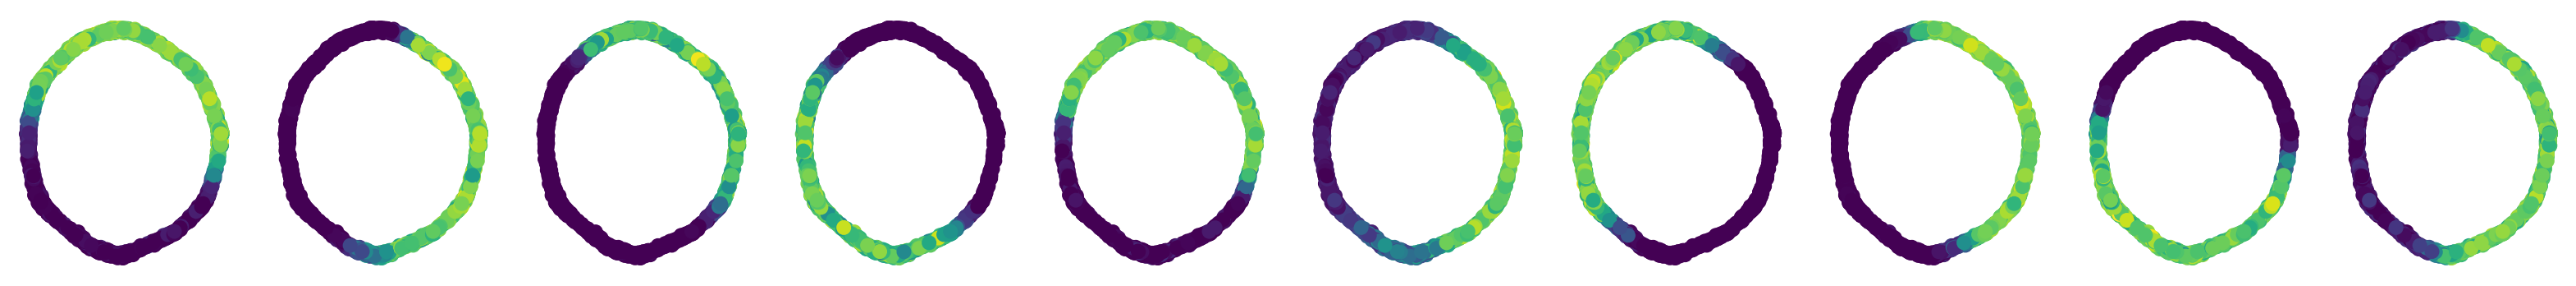

In [11]:
n_plots=10
start_idx=300
fig,axes = plt.subplots(1,n_plots, figsize=(n_plots*2,2))
for i, ax in enumerate(axes.flat):
    ax.scatter(*a.obsm["pcs"][:, :2].T,s = 30, c= a[:, ranking[i+start_idx]].X.A.flatten())
    ax.axis("off")

In [12]:
from sklearn.cluster import MiniBatchKMeans as kmeans

In [13]:
km=kmeans(4)
km.fit(a.X.A[::10, ranking[:300]].T)
labels=km.predict(a.X.A[::10, ranking[:300]].T)

Text(72.22222222222221, 0.5, 'genes')

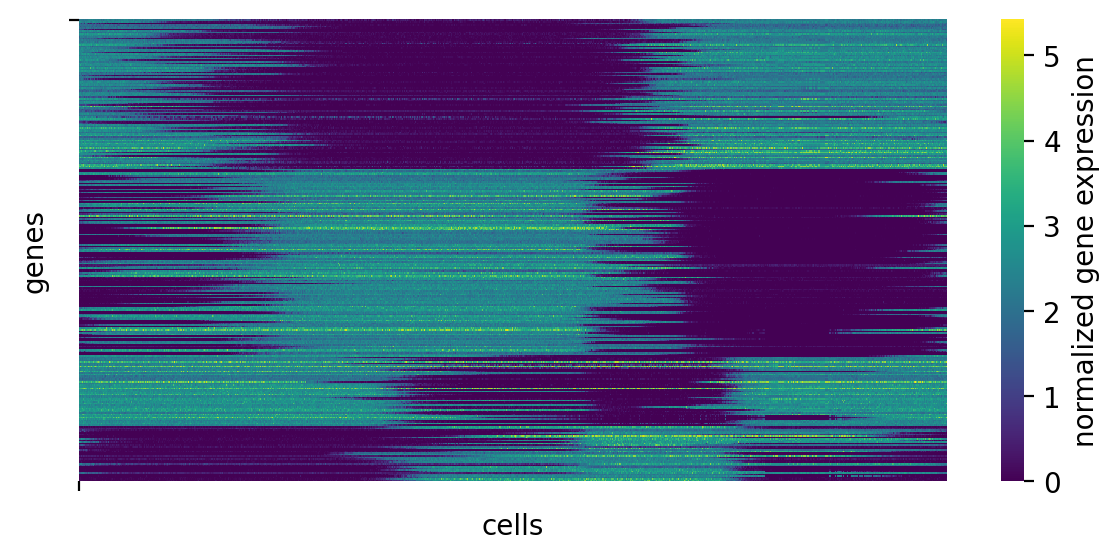

In [14]:
plt.figure(figsize=(7,3))
sns.heatmap(
    a.X.A[cell_ordering][:, ranking[:300]][:, np.argsort(labels)].T, 
    cmap = "viridis",
    xticklabels=[""],yticklabels=[""], cbar_kws={"label": "normalized gene expression"}

)
plt.xlabel("cells")
plt.ylabel("genes")

We can also visualize the gene expression as a function of the loop trajectory.

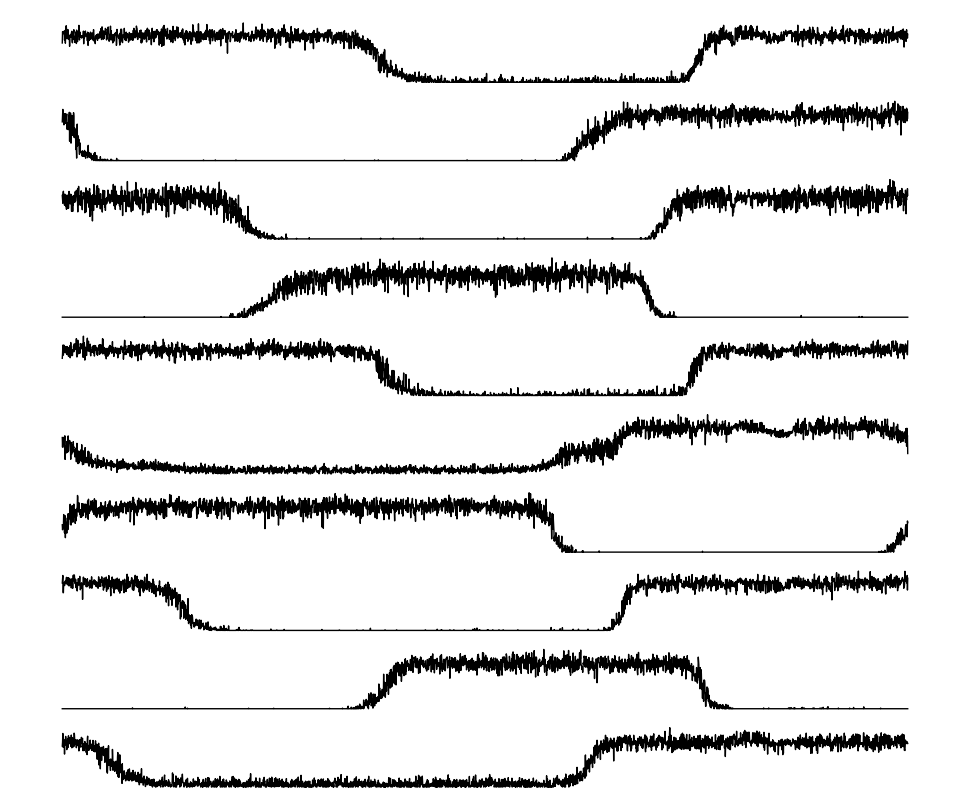

In [15]:
n_plots=10
start_idx=300
fig,axes = plt.subplots(n_plots,1, figsize=(6, n_plots*.5))
for i, ax in enumerate(axes.flat):
    ax.plot(a.X.A[cell_ordering][:, ranking[i+start_idx]], linewidth=.5, color = "black")
    ax.axis("off")

Now we can ask if our ranking is really topologically meaningful.

To do this let's first compute the topology on the first 500 ranked genes.

In [16]:
reduced_space = a[:, ranking[:500]]

In [17]:
topology_reduced = simplicial.SimplicialTopology(reduced_space.X.A, n_pts = 400)

In [18]:
%%time
topology_reduced.compute_persistent_cohomology(verbose=True)

Doing TDA...
Elapsed time persistence: 0.978 seconds
CPU times: user 977 ms, sys: 3.62 ms, total: 981 ms
Wall time: 980 ms


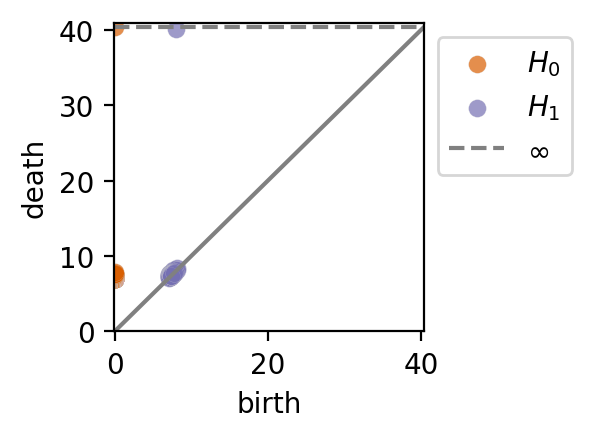

In [19]:
diagrams.plot_pers_diag_ripser(topology_reduced.ph.dgms_)

Since there's still a large homology class we can see that the topology is preserved. Now, let's calculate the topology of the last 500 genes. 

Doing TDA...
Elapsed time persistence: 0.79 seconds


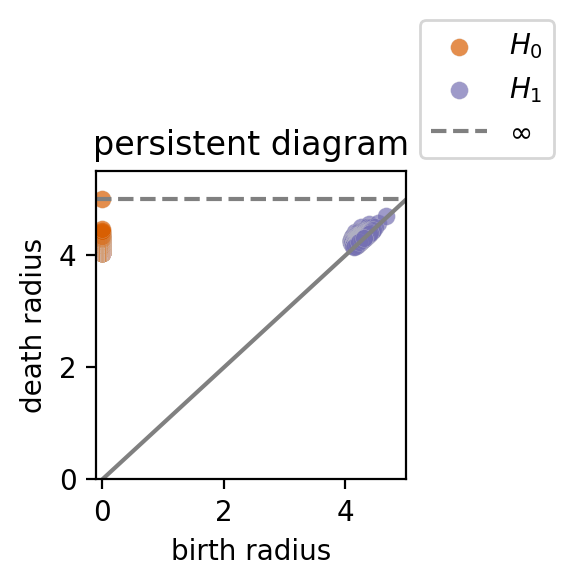

In [21]:
complement = a[:, ranking[-500:]]

complement_topo = simplicial.SimplicialTopology(complement.X.A, n_pts = 400)
complement_topo.compute_persistent_cohomology(verbose=True)
diagrams.plot_pers_diag_ripser(complement_topo.ph.dgms_)

We can see that there's no prominent 1-homology class, and hence the topology of the data vanishes. Let's see what genes are in the top 50 rank.

In [25]:
a.var.iloc[ranking[:50]].index

Index(['Target863', 'Target624', 'Target582', 'B3_TF3', 'Target799',
       'Target584', 'Target954', 'C1_TF9', 'Target822', 'Target606',
       'Target570', 'Target109', 'Target642', 'Target323', 'Target305',
       'Target182', 'Target498', 'Target413', 'Target275', 'Target72',
       'Target332', 'C2_TF1', 'Target60', 'Target409', 'Target9', 'Target801',
       'Target340', 'Target104', 'Target503', 'Target138', 'Target154',
       'Target344', 'Target186', 'Target577', 'Target301', 'Target636',
       'Target354', 'Target15', 'Target235', 'Target566', 'Target407',
       'Target868', 'Target302', 'Target247', 'Target272', 'Target181',
       'Target140', 'Target884', 'Target571', 'Target260'],
      dtype='object')

We can see that most are target genes and some are TFs. Now let's check the last 50 genes.

In [24]:
a.var.iloc[ranking[-50:]].index

Index(['HK496', 'HK107', 'HK172', 'HK119', 'HK289', 'HK248', 'HK249', 'HK258',
       'HK262', 'Target5', 'HK270', 'HK271', 'HK277', 'HK365', 'HK290',
       'HK238', 'HK301', 'HK356', 'HK310', 'HK352', 'HK317', 'HK319', 'HK321',
       'HK328', 'HK339', 'HK246', 'HK235', 'HK123', 'HK174', 'HK132', 'HK134',
       'HK143', 'HK450', 'HK150', 'HK152', 'HK154', 'HK163', 'HK164', 'HK186',
       'HK230', 'Target180', 'HK190', 'HK196', 'HK204', 'HK205', 'HK402',
       'HK218', 'HK226', 'HK229', 'HK500'],
      dtype='object')

We can see that the last 50 ranked genes are mostly housekeeping genes.